#### The following notebook walks you thru the steps of Data Cleaning, Data Engneering and EDA.

___

In [1]:
# priting over 1 line of code within the same cell

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
# importing required libraries
import pandas as pd
import numpy as np

# Visualization
import missingno
import matplotlib.pyplot as plt
import seaborn as sns

# extra
import warnings
warnings.filterwarnings('ignore')

In [3]:
# reading df

df = pd.read_csv('../files/blocks.csv')

<AxesSubplot:>

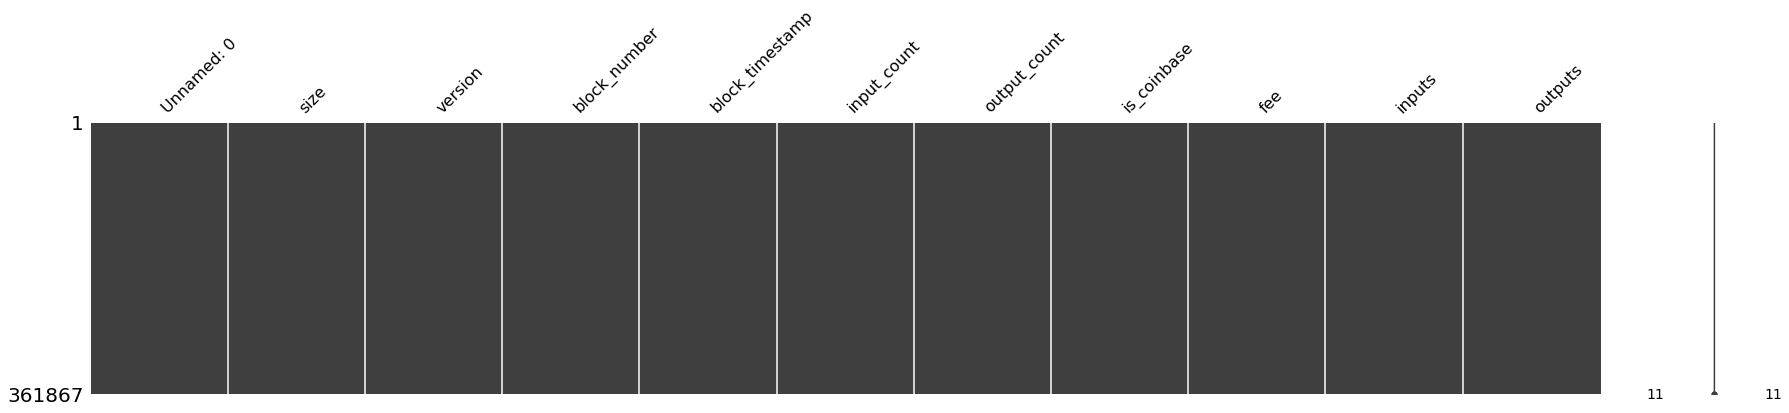

In [4]:
# checking if there are missing values

missingno.matrix(df, figsize = (30,5)) # no missing values

<br>

#### Let's do some data exploration and data cleaning.

___

In [5]:
# visualizing the df

df.head()

,Unnamed: 0,size,version,block_number,block_timestamp,input_count,output_count,is_coinbase,fee,inputs,outputs
0,0,816,1,679250,2021-04-14 23:51:48+00:00,5,2,False,62493.0,"[{'index': 0, 'spent_transaction_hash': 'b4788...","[{'index': 0, 'script_asm': 'OP_DUP OP_HASH160..."
1,1,224,1,679250,2021-04-14 23:51:48+00:00,1,2,False,13560.0,"[{'index': 0, 'spent_transaction_hash': 'ff2a7...","[{'index': 0, 'script_asm': 'OP_HASH160 ad2c3a..."
2,2,224,1,679250,2021-04-14 23:51:48+00:00,1,2,False,17920.0,"[{'index': 0, 'spent_transaction_hash': '6d452...","[{'index': 0, 'script_asm': 'OP_HASH160 d805ef..."
3,3,368,2,679250,2021-04-14 23:51:48+00:00,1,2,False,14098.0,"[{'index': 0, 'spent_transaction_hash': '8a56b...","[{'index': 0, 'script_asm': '0 a88573af66089b1..."
4,4,226,1,679250,2021-04-14 23:51:48+00:00,1,2,False,17479.0,"[{'index': 0, 'spent_transaction_hash': '45a2e...","[{'index': 0, 'script_asm': 'OP_DUP OP_HASH160..."


In [6]:
df.shape
df.info()

(361867, 11)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 361867 entries, 0 to 361866
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Unnamed: 0       361867 non-null  int64  
 1   size             361867 non-null  int64  
 2   version          361867 non-null  int64  
 3   block_number     361867 non-null  int64  
 4   block_timestamp  361867 non-null  object 
 5   input_count      361867 non-null  int64  
 6   output_count     361867 non-null  int64  
 7   is_coinbase      361867 non-null  bool   
 8   fee              361867 non-null  float64
 9   inputs           361867 non-null  object 
 10  outputs          361867 non-null  object 
dtypes: bool(1), float64(1), int64(6), object(3)
memory usage: 28.0+ MB


### Columns Description:

- |__Unnamed: 0__| -> Redundant column of the index. _'int64'_
- |__Hash__| -> The hash of this transaction. _'int64'_
- |__Size__| -> The size of block data in bytes. _'int64'_
- |__Virtual size__| -> The virtual transaction size (differs from size for witness transactions). _'int64'_
- |__Version__| -> Protocol version specified in block which contained this transaction. _'object'_
- |__Lock time__| -> Earliest time that miners can include the transaction in their hashing of the Merkle root to attach it in the latest. _'object'_
- |__Block hash__| -> Hash of the block which contains this transaction. _'int64'_
- |__Block number__| -> Number of the block which contains this transaction. _'int64'_
- |__block timestamp__| -> Timestamp of the block which contains this transaction. _'object'_
- |__Block timestamp month__| -> Month of the block which contains this transaction. _'int64'_
- |__Input count__| -> The number of inputs in the transaction. _'int64'_
- |__Output count__| -> The number of outputs in the transaction. _'int64'_
- |__Input value__| -> Total value of inputs in the transaction in satoshis. _'int64'_
- |__Output value__| -> Total value of outputs in the transaction in satoshis. _'int64'_
- |__Is coinbase__| -> Max amount of sets that can be played in a match. _'bool'_
- |__Fee__| -> The fee paid by this transaction in sats. _'float64'_
- |__Inputs__| -> Transaction inputs. _'object'_
- |__Outputs__| -> Transaction outputs. _'object'_

<br>

#### Checking all columns and changing the type in case it's needed

In [7]:
# index column and Unnamed

df.index
df['Unnamed: 0']

RangeIndex(start=0, stop=361867, step=1)

0              0
1              1
2              2
3              3
4              4
           ...  
361862    361862
361863    361863
361864    361864
361865    361865
361866    361866
Name: Unnamed: 0, Length: 361867, dtype: int64

In [8]:
# dropping redundant columns

df.drop(columns= 'Unnamed: 0', inplace= True)

<br>

In [9]:
df['version'].dtype

dtype('int64')

In [10]:
# most nodes are using the version 1

df['version'].value_counts()

1    231187
2    130680
Name: version, dtype: int64

<br>

In [11]:
# blocks are for Apr 14th

df['block_number'].min()
df['block_number'].max()

679250

679422

In [79]:
df['block_number'].value_counts()

679327    3153
679278    3045
679359    3037
679328    3002
679346    2993
          ... 
679290     937
679333     818
679376     796
679309     642
679317     570
Name: block_number, Length: 173, dtype: int64

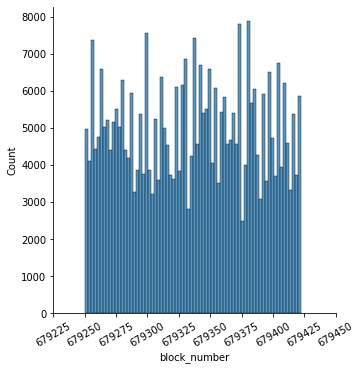

In [13]:
# amount of tx per block

sns.displot(x= 'block_number', data= df).set_xticklabels(rotation=30);

<br>

In [14]:
# converting to proper type

df['block_timestamp']= pd.to_datetime(df.block_timestamp).dt.tz_localize(None)

In [15]:
df['block_timestamp'].min()
df['block_timestamp'].max()

Timestamp('2021-04-14 23:51:48')

Timestamp('2021-04-15 23:55:33')

In [16]:
df['block_number'].value_counts()

679327    3153
679278    3045
679359    3037
679328    3002
679346    2993
          ... 
679290     937
679333     818
679376     796
679309     642
679317     570
Name: block_number, Length: 173, dtype: int64

<AxesSubplot:xlabel='block_timestamp', ylabel='block_number'>

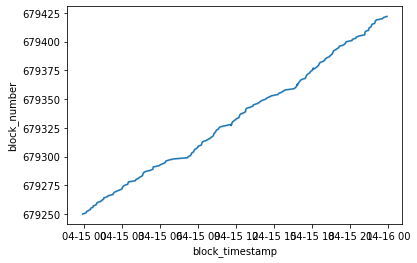

In [17]:
sns.lineplot(x= 'block_timestamp', y= 'block_number', data= df)

<br>

<br>

In [51]:
# big majority of tx have 1 input

len(df['input_count'].value_counts())

513

In [62]:
len(df[df['input_count']== 1])

272380

In [72]:
small_inp= df[df['input_count'] < 5]

In [73]:
len(small_inp)

342406

In [76]:
small_inp['input_count'].value_counts(normalize= True)

1    0.795488
2    0.141729
3    0.042412
4    0.019865
0    0.000505
Name: input_count, dtype: float64

<br>

<br>

In [81]:
# same happens with output... unless the UTXO is spent completely most outputs are 2 cuz of the change address
# prolly very big numbers of inputs/outputs come from mixers

df['output_count'].value_counts()

2      232330
1       93397
3       13213
4        4314
5        2726
        ...  
620         1
514         1
357         1
520         1
510         1
Name: output_count, Length: 263, dtype: int64

In [ ]:
sample_input = df[df["block_number"] == 679327]["inputs"][156225]

In [ ]:
sample_cleaned = "".join("".join(sample_input.split('[')).split("]")[:-1])

In [ ]:
print(sample_cleaned)

In [ ]:
sample_cleaned_1 = sample_cleaned.split("\n ")[1]
sample_cleaned_1 = sample_cleaned_1.replace("'", "").replace("{", "").replace("}", "").replace("array(", "")

In [ ]:
data_dict = {}

for e in sample_cleaned_1.split(", "):
    
    le = e.split(": ")
    
    if len(le) == 1:
        pass
    
    else:
        
        key_ = le[0]
        value_ = le[1]

        data_dict[key_] = value_
    

In [ ]:
CAST_TO_NUM = ["index", "spent_output_index", "sequence", "required_signatures", "value"]

In [ ]:
for num_key in CAST_TO_NUM:
    
    if num_key == "value":
        decimal_str = data_dict[num_key]
        amount = float(decimal_str.split("(")[1][:-1])
        data_dict[num_key] = amount
        
    else:
        str_num = data_dict[num_key]
        data_dict[num_key] = int(str_num)

In [ ]:
pd.DataFrame(data_dict, index = [1])

In [ ]:
# TO DO
# 1. clean_data_dict (data_dict)

In [ ]:
raw = df["inputs"].values.tolist()
raw

In [ ]:
len(raw)